The notebook must be run several times to produce the "model_name_results.csv" files.

For each run, change the "penalty_" variable and rerun the notebook.

In [1]:
# define the penalty (or premium if <1) for under-predicting.
penalty_ = 1.0

# 0 Modules, path, etc

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# import modules
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import data_table

# use data table provided by Colab
data_table.enable_dataframe_formatter()

Run the following line if the Colab start having trouble navigating directories.

In [4]:
# reset the path
import os
path = "/content" # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path)

In [5]:
# check directory
!pwd

/content


In [6]:
# set directory
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


# 1 Data Preparation

The panel.csv contains: 

*   **Labels:** Load (electricity demand in MW) for different weather zones in Texas. The Weather Zones are shown in the figure below.
*   **Inputs:** Weather data (temperature, dew, humidity, etc) taken from the four largest cities in the state (Dallas, Houston, San Antonio and Austin).


In [7]:
# inputs
x = pd.read_csv("panel.csv")
x

,load_coast,cloudcover_houston,dew_houston,feelslike_houston,humidity_houston,precip_houston,sealevelpressure_houston,solarradiation_houston,temp_houston,visibility_houston,windspeed_houston,hour,day_name,weekend,month,year,season,date
0,7607.189871,64.6,19.8,20.0,98.78,0.000,1013.6,0.0,20.0,8.6,11.0,0,Tuesday,False,1,2013,winter,2013-01-01 00:00:00
1,7389.267519,65.5,19.3,20.0,95.76,0.014,1013.6,0.0,20.0,6.0,9.2,1,Tuesday,False,1,2013,winter,2013-01-01 01:00:00
2,7179.748411,100.0,19.0,19.4,97.31,0.000,1013.9,0.0,19.4,3.5,10.2,2,Tuesday,False,1,2013,winter,2013-01-01 02:00:00
3,7039.692524,100.0,18.3,18.5,99.10,1.863,1013.7,0.0,18.5,3.1,17.6,3,Tuesday,False,1,2013,winter,2013-01-01 03:00:00
4,6991.412764,100.0,15.9,16.1,99.12,1.546,1013.6,0.0,16.1,9.5,22.7,4,Tuesday,False,1,2013,winter,2013-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61339,11109.257860,7.3,-6.6,13.9,23.66,0.000,1021.8,0.0,13.9,16.0,0.0,19,Tuesday,False,12,2019,winter,2019-12-31 19:00:00
61340,10846.500060,6.1,-5.5,13.8,25.77,0.000,1022.0,0.0,13.8,16.0,0.8,20,Tuesday,False,12,2019,winter,2019-12-31 20:00:00
61341,10592.539870,7.3,-5.3,12.9,27.81,0.000,1022.0,0.0,12.9,13.3,1.0,21,Tuesday,False,12,2019,winter,2019-12-31 21:00:00
61342,10304.624870,9.2,-2.5,12.9,34.29,0.000,1022.0,0.0,12.9,8.8,5.6,22,Tuesday,False,12,2019,winter,2019-12-31 22:00:00


Clean the data, normalize it.

In [8]:
# check for nans
x.isna().sum()
x = x.dropna()

# fix dates
x['date'] = pd.to_datetime(x['date'], infer_datetime_format=True)

# set index
x = x.set_index('date')

# restrict the amount of data used
x = x.loc[(2014 <= x.index.year) & (x.index.year <= 2018)]

# add year as explanatory variable
x['year'] = x.index.year - min(x.index.year)

# sort everything
x = x.sort_values(["date"])

# splits labels and inputs
y = x.filter(like='load')

# take the categorical data off
cat = ['day_name','weekend','month','season']
x_cat = x[cat].astype(str)
x_cat = pd.get_dummies(x_cat)
x = x.drop(cat,axis=1)

# normalize data
x_mean = x.mean()
y_mean = y.mean()
x_std  = x.std()
y_std  = y.std()
x = (x - x_mean) / x_std
y = (y - y_mean) / y_std
# norm_x = (norm_x * x_std) + x_mean

# put the categorical variables back
x = pd.concat([x,x_cat],axis=1)

# choose labels and inputs
y = y[['load_coast']]

# free memory
del cat, x_cat

Put the data in time series format, use the last "n_past" steps to predict the next "n_future" observations.

In [9]:
# setting step size
n_past = 96
n_future = 24

# put data in (n_obs x timesteps x n_features)
x_ts = []
y_ts = []
for i in range(n_past, len(x) - (n_future + 1)):
    x_ts.append(x.iloc[(i-n_past):i,0:x.shape[1]])
    y_ts.append(y.iloc[(i):(i+n_future), :])

# transform everything to numpy arrays
x_ts, y_ts = np.array(x_ts), np.array(y_ts)
y_ts = y_ts[:,:,0]

Split the train and test datasets.

In [10]:
# train the model using the initial 1500 days
x_train = x_ts[:36000]
y_train = y_ts[:36000]

# validate the model using the final one years
x_test = x_ts[36000:x_ts.shape[0]]
y_test = y_ts[36000:y_ts.shape[0]]

# number of inputs and labels
n_inputs = x.shape[1]
n_labels = y.shape[1]

In [11]:
# check
print('x_train shape:', x_train.shape)
print('x_train types:', x_train.dtype)
print('y_train types:', y_train.dtype)

x_train shape: (36000, 96, 38)
x_train types: float64
y_train types: float64


# 2 Deep Learning Model

Set the Tensor Processing Units.

In [12]:
# This address identifies the TPU we'll use when configuring TensorFlow.
tpu_worker = 'grpc://' + os.environ['COLAB_TPU_ADDR']

# get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_worker)

# connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# set the distribution strategy
strategy = tf.distribute.TPUStrategy(resolver)

Define the loss functions

In [13]:
# custom mse with penalty
def penalized_mse(y_true,y_pred):
    penalty = penalty_
    diff = tf.subtract(y_true, y_pred)
    loss = tf.where(tf.greater(diff,0.0), diff * penalty_, diff)
    squared = tf.square(loss)
    return tf.reduce_mean(squared)

# test the penalized mse
print(penalized_mse([[2.0]],[[1.0]]))
print(penalized_mse([[1.0]],[[2.0]]))

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


Import the ingredients used in the model.

In [14]:
# import things from Keras and TensorFlow
from keras.models    import Sequential
from keras.layers    import Conv1D, GRU, Dense, Dropout, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras           import backend as K

In [15]:
#set model for tpu
with strategy.scope():

  model = Sequential([
      # Conv1D(filters=64, kernel_size=2,strides=2, padding="valid", activation="relu", input_shape=(x_train.shape[1],x_train.shape[2])),
      # Conv1D(filters=64, kernel_size=1, strides=1, padding="causal", activation="relu"),
      GRU(48, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])),
      GRU(256, return_sequences=False),
      # Flatten(),
      Dense(256, activation = "relu"),
      Dropout(0.1),
      Dense(128, activation="relu"),
      Dense(64, activation="relu"),
      Dropout(0.1),
      Dense(32, activation="relu"),
      # Flatten(),
      Dropout(0.1),
      Dense(n_future)
  ])

  # compile the model
  model.compile(optimizer = 'adam', loss = penalized_mse, metrics = ['mae','mse','mape'])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.5, beta_1=1e-6)
  reduce_learning_rate = ReduceLROnPlateau(monitor='val_mae',factor=0.2, patience=10, mode='auto')

# # check if inputs and outputs are coherent
# model.summary()

In [16]:
# use model weights from the case where penalty_ = 1 to speed up things
model.load_weights('weights/gru.h5')

In [17]:
%%time

# model fit
history = model.fit(
    x_train, 
    y_train, 
    validation_split=0.1, 
    verbose=1, 
    epochs=50,
    batch_size = 32,
    shuffle=False,
    validation_data = (x_test, y_test),
    callbacks=[reduce_learning_rate]
    )

Epoch 1/50
1125/1125 [==============================] - 29s 22ms/step - loss: 0.0542 - mae: 0.1780 - mse: 0.0542 - mape: 112.5728 - val_loss: 0.1864 - val_mae: 0.3031 - val_mse: 0.1864 - val_mape: 149.4606 - lr: 0.0010
Epoch 2/50
1125/1125 [==============================] - 20s 18ms/step - loss: 0.0633 - mae: 0.1922 - mse: 0.0633 - mape: 127.4816 - val_loss: 0.1610 - val_mae: 0.2902 - val_mse: 0.1610 - val_mape: 158.0577 - lr: 0.0010
Epoch 3/50
1125/1125 [==============================] - 21s 19ms/step - loss: 0.0659 - mae: 0.1957 - mse: 0.0659 - mape: 124.0264 - val_loss: 0.1443 - val_mae: 0.2753 - val_mse: 0.1443 - val_mape: 140.4312 - lr: 0.0010
Epoch 4/50
1125/1125 [==============================] - 21s 18ms/step - loss: 0.0622 - mae: 0.1909 - mse: 0.0622 - mape: 128.0393 - val_loss: 0.2438 - val_mae: 0.3527 - val_mse: 0.2438 - val_mape: 159.5603 - lr: 0.0010
Epoch 5/50
1125/1125 [==============================] - 21s 18ms/step - loss: 0.0622 - mae: 0.1905 - mse: 0.0622 - mape: 122

Save the model weights.

In [18]:
# save model
model_name = 'gru_custom_loss_' + str(penalty_) + '_penalty'
model.save_weights('weights/' + model_name + '.h5', overwrite=True)

In [19]:
# export history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('histories/' + model_name + '_history.csv')

# 3 Export Results.

Run this cell if loading weights.

In [20]:
# model.load_weights('weights/' + model_name + '.h5')

Forecasting and model evaluation

In [21]:
# model predictions
y_fit = model.predict(x_test)

241/241 [==============================] - 4s 14ms/step


Descale the forecasted values.

In [22]:
# descale the predictions
y_fit = (y_fit * y_std[0]) + y_mean[0]
y_test = (y_test * y_std[0]) + y_mean[0]

These are the dates where the forecasting starts.

For example, "2016-10-01 02:00:00" means that the first forecasted hour is 2 AM of date 2016-10-01.

In [23]:
# first forecasted datetime
y_dates = []
for i in range(n_past, len(x) - (n_future + 1)):
    y_dates.append(y.index[i])

# put results in a dataframe
results = pd.DataFrame(index=y_dates)
results.index.name = 'datetime'
results = results[36000:x_ts.shape[0]]

# drop results and actual values for all forecasted hours
for h in range(0,y_fit.shape[1]):
  results['fit_' + str(h)] = y_fit[:,h]
  results['actual_' + str(h)] = y_test[:,h]

# export results
results.to_csv('results/' + model_name + '_results.csv')

# 4 Error Graphs

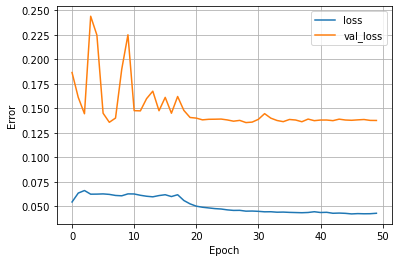

In [24]:
# plot
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_mse'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.savefig('graphs/' + model_name + '_training.pdf')

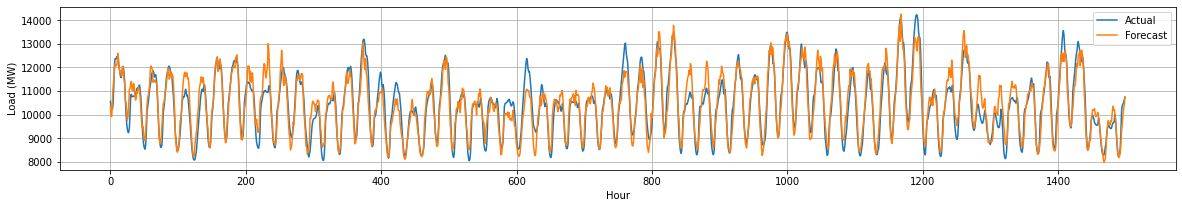

In [25]:
# plot
plt.figure(figsize=(20,3))
plt.plot(y_test[0:1500,0], label='Actual')
plt.plot(y_fit[0:1500,0], label='Forecast')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.savefig('graphs/' + model_name + '_fit.pdf')

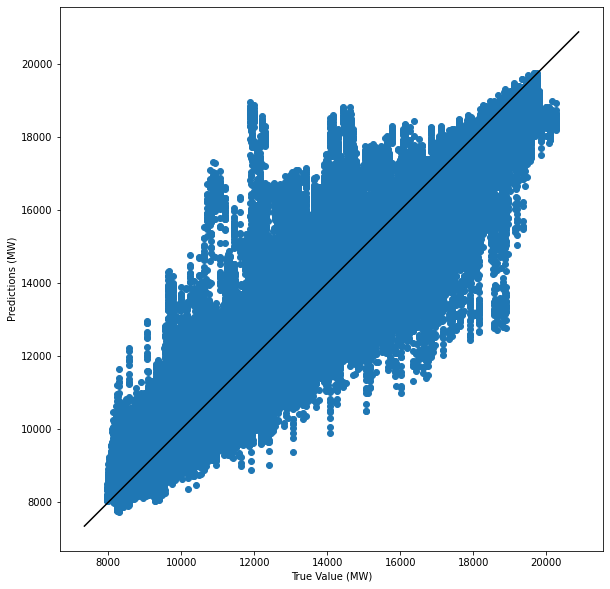

In [26]:
# comparison between predicted and actual values
plt.figure(figsize=(20,10))
a = plt.axes(aspect='equal')
plt.scatter(y_test[:], y_fit[:])
b = np.linspace(*a.get_xlim())
a.plot(b, b, color='black')
plt.xlabel('True Value (MW)')
plt.ylabel('Predictions (MW)')
plt.savefig('graphs/' + model_name + '_comparison.pdf')

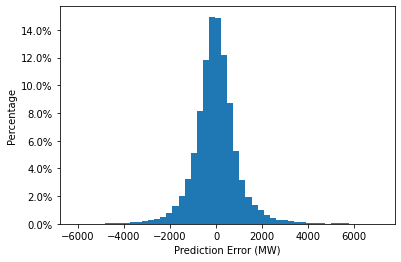

In [27]:
# error histogram
from matplotlib.ticker import PercentFormatter
error = (y_fit - y_test).flatten()
plt.hist(error, bins = 50, weights=np.ones(len(error)) / len(error))
plt.xlabel("Prediction Error (MW)")
_ = plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('graphs/' + model_name + '_errordist.pdf')